### Boilerplate

In [1]:
import tqdm, numpy as np
import matplotlib.pyplot as plt
import utils
import umap
import hdbscan
import matplotlib.pyplot as plt
import logging
from bson.objectid import ObjectId
import gc
import tasks
from sklearn.preprocessing import StandardScaler
import numba
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances
import umap.plot
from sklearn.cluster import KMeans

# for jupyter notebook widgets
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from ipywidgets import interact, interactive

In [2]:
# connect to database
db = utils.connect()
db

Database(MongoClient(host=['20.220.215.35:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', authmechanism='SCRAM-SHA-256', connecttimeoutms=50000, serverselectiontimeoutms=50000, directconnection=True, replicaset='rs0'), 'aita')

### Setup Human Clusters

In [3]:
# hardcoded group id strings
group_id_strings = ['63901a89e189962b660959cf', '63901a92931eeac91c9924a1', '63901a96e189962b660959d3']

# convert to objectId's
group_ids = [ObjectId(str(id)) for id in group_id_strings]

# retrieve groups from database
groups = list(db.groups.find({"_id":{"$in" : group_ids}}))
print("Retrieved " + str(len(groups)) + " groups from database")

Retrieved 3 groups from database


In [4]:
groups[0]['history'][0]['included_documents']

['hetv62', 'lwd55z', 'dhbdpv', 'eyj0sv']

In [5]:
# projection here to only include the fields we want
projection = {'id': 1, 'textVector': 1}
projection

{'id': 1, 'textVector': 1}

### Create Training Set

Options to define training set:
1. Use the first groups teleoscope ordering
2. Use all documents
3. Create a new teleo vec from all documents in human clusters

Embeddings
- save training set upon creation (check if created or not)
    - we need to save both ids and vectors for recall at the end

#### Save & Create Training Data

##### Using First Group's Teleoscope Ordering

Change Raw cells below to Code if you need to reload document ids / vectors

#### Load Training Data

##### Using First Group's Teleoscope Ordering

In [6]:
loaded = np.load('teleo_order_docs.npz')
document_ids = loaded['doc_ids'].tolist()
document_vectors = loaded['doc_vecs']
document_ids[1500]


'c0xy3x'

#### Append documents in human clusters

In [7]:
i = 0
for group in groups:
    
    # grab latest history item for each group
    group_document_ids = group["history"][0]["included_documents"]
    
    for id in group_document_ids:
        
        try:
            index = document_ids.index(id)
            indices.append(index)
        
        except:
            document = db.documents.find_one({"id": id}, projection=projection)
            document_ids.append(id)
            vector = np.array(document["textVector"]).reshape((1, 512))
            document_vectors = np.append(document_vectors, vector, axis=0)

    i += 1
    
    print(f'\nAdding group {i}')
    print("Document ids has the shape: ", len(document_ids))
    print("Document vectors has the shape: ", document_vectors.shape)


Adding group 1
Document ids has the shape:  10004
Document vectors has the shape:  (10004, 512)

Adding group 2
Document ids has the shape:  10011
Document vectors has the shape:  (10011, 512)

Adding group 3
Document ids has the shape:  10016
Document vectors has the shape:  (10016, 512)


### Clustering

#### UMAP

Notes
- DR by default hyperparameters
- low_memory uses less memory but longer compute time
- verbose just logs info

TODO
- define custom metric
- what args are passed to custom metric
- how do we check if args are a subset of group?
- can we use conditional or do we need matrix

ISSUES
- general 
    - how to check if i and j are in the same group
    - i and j are vectors
    - is it possible to pass i and j as indices instead of vectors?
- conditional metric
    - groups contain ids
    - maybe search for indices of both id and vec then compare? seems expensive
    - maybe translate vec to id (or visversa) then compare? seems expensive
    - add a new dimension that is the id of vector for easy lookup
- matrix metric
    - use metric='precomputed'
    - expensive as fuck to build matrix
    - how to reduce cost?

##### Custom Metric

##### Organize Document IDs & Indices in Human Clusters

In [8]:
# use dict or ndarray?
group_doc_indices = {}
group_doc_ids = {}

for group in range(len(groups)):
    
    curr_id = groups[group]['history'][0]['included_documents']
    
    indices = []
    ids = []
    
    for i in curr_id:
        indices.append(document_ids.index(i))
        ids.append(i)
    
    group_doc_indices[group] = indices
    group_doc_ids[group] = ids
    
print(group_doc_indices)
print(group_doc_ids)

{0: [5630, 7789, 2801, 3965], 1: [10004, 10005, 10006, 10007, 6135, 9393, 10010], 2: [10011, 10012, 10013, 10014, 10015]}
{0: ['hetv62', 'lwd55z', 'dhbdpv', 'eyj0sv'], 1: ['g3y7dc', 'j8nzf5', 'fs0vuw', 'q9zlgr', 'ia4w5v', 'ruuxs1', 'hw16a9'], 2: ['mnqbp9', 'spk73c', 'qqwzth', 'dfon3v', 'bqafew']}


##### Create Distance Matrix

In [9]:
# using sklean euclidean distances
dm = euclidean_distances(document_vectors)
dm.shape

(10016, 10016)

##### Update Distances for Documents within the same human cluster

In [10]:
# TODO - SIMPLIFY THIS METHOD USING MAP FUNCTION
for group in range(len(groups)):
    
    docs = groups[group]['history'][0]['included_documents']

    for i in range(len(docs)):
        
        index_i = document_ids.index(docs[i])
        
        for j in range(len(docs)):
        
            index_j = document_ids.index(docs[j])
            dm[index_i, index_j] = 0 


In [11]:
# sanity check to make sure two docs in the same human cluster are distance 0
i = group_doc_indices[0][2]
j = group_doc_indices[0][3]
dm[i,j] == 0

True

##### Reduction

In [55]:
umap_embeddings = umap.UMAP(
    verbose=True,
    low_memory=True,
    metric="precomputed", # use distance matrix
    n_components=5, # reduce to 5 dimensions
    n_neighbors=10,
    min_dist=0.1,
).fit_transform(dm)

/Users/leofk/opt/anaconda3/envs/mallard/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', n_components=5, n_neighbors=10, verbose=True)
Wed Jan 25 17:55:59 2023 Construct fuzzy simplicial set
Wed Jan 25 17:55:59 2023 Finding Nearest Neighbors
Wed Jan 25 17:55:59 2023 Finished Nearest Neighbor Search
Wed Jan 25 17:56:00 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Jan 25 17:56:03 2023 Finished embedding


In [56]:
umap_embeddings.shape

(10016, 5)

In [57]:
# compute inter cluster distances for human groups
for group in range(len(groups)):
    
    docs = groups[group]['history'][0]['included_documents']
    print(f'Group {group}')
    dst = []
    
    for i in range(len(docs)):
        
        index_i = document_ids.index(docs[i])
        a = umap_embeddings[index_i]
        
        for j in range(len(docs)):
        
            index_j = document_ids.index(docs[j])
            b = umap_embeddings[index_j]
            euc_a_b = euclidean_distances([a],[b])[0][0]
            dst.append(euc_a_b)
            # print(f'dist({index_i}, {index_j}) = {euc_a_b}')
    
    mean = sum(dst) / len(dst)
    print(f'AVG Dist = {mean}\n')

Group 0
AVG Dist = 0.16823291406035423

Group 1
AVG Dist = 0.04012156384331839

Group 2
AVG Dist = 0.04241841197013855



#### HDBSCAN

Notes
- Clustering by default hyperparameters
- Resultant labels are in the same ordering as data

TODO
- User parameterize hyperparams
- Use custom metric hyperparam here too?

In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(
    min_cluster_size=10,    # num of neighbouring points needed to be considered a cluster
    min_samples=None,         # how conservative clustering will be. larger is more conservative.
    cluster_selection_epsilon=0.3,   # determines what it means for points to be “close”
).fit_predict(umap_embeddings)

print(f'Num Clusters = {max(hdbscan_labels)+1} + outliers')

Num Clusters = 22 + outliers


#### Results
Are human clusters maintained?

In [63]:
label_array = np.array(hdbscan_labels)
clusters = {}

# iterate over given labels
for hdbscan_label in set(hdbscan_labels):
        
        # find indices of documents for a current label
        document_indices_scalar = np.where(label_array == hdbscan_label)[0]
        document_indices = [int(i) for i in document_indices_scalar]
        
        # create list of document ids that are in current label
        documents = []
        
        for i in document_indices:
            documents.append(document_ids[i])
        
        # add label and respective document ids to clusters dictionary
        clusters[hdbscan_label] = documents
        

In [94]:
# examine matchings between human labelled clusters and machine labelled clusters
for group in group_doc_indices:
    print(f'\nLabels for group = {group}\n')
    for index in group_doc_indices[group]:
        print(document_ids[index], hdbscan_labels[index])


Labels for group = 0

hetv62 19
lwd55z 19
dhbdpv 19
eyj0sv 19

Labels for group = 1

g3y7dc 15
j8nzf5 15
fs0vuw 15
q9zlgr 15
ia4w5v 15
ruuxs1 15
hw16a9 15

Labels for group = 2

mnqbp9 12
spk73c 12
qqwzth 12
dfon3v 12
bqafew 12


### Visualize

In [89]:
mapper = umap.UMAP(
    verbose=True,
    low_memory=True,
    n_components=2, # reduce to 2 dimensions
).fit(umap_embeddings)
twod_umap = mapper.transform(umap_embeddings)

UMAP( verbose=True)
Wed Jan 25 18:08:39 2023 Construct fuzzy simplicial set
Wed Jan 25 18:08:39 2023 Finding Nearest Neighbors
Wed Jan 25 18:08:39 2023 Building RP forest with 10 trees
Wed Jan 25 18:08:39 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Wed Jan 25 18:08:39 2023 Finished Nearest Neighbor Search
Wed Jan 25 18:08:39 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Jan 25 18:08:43 2023 Finished embedding


In [92]:
hdbscan_labels = hdbscan.HDBSCAN(
    min_cluster_size=20,            # num of neighbouring points needed to be considered a cluster
    min_samples=None,               # how conservative clustering will be. larger is more conservative.
    cluster_selection_epsilon=0.5,   # what it means for points to be “close”
).fit_predict(twod_umap)

print(f'Num Clusters = {max(hdbscan_labels)+1} + outliers')

Num Clusters = 20 + outliers


<AxesSubplot:>

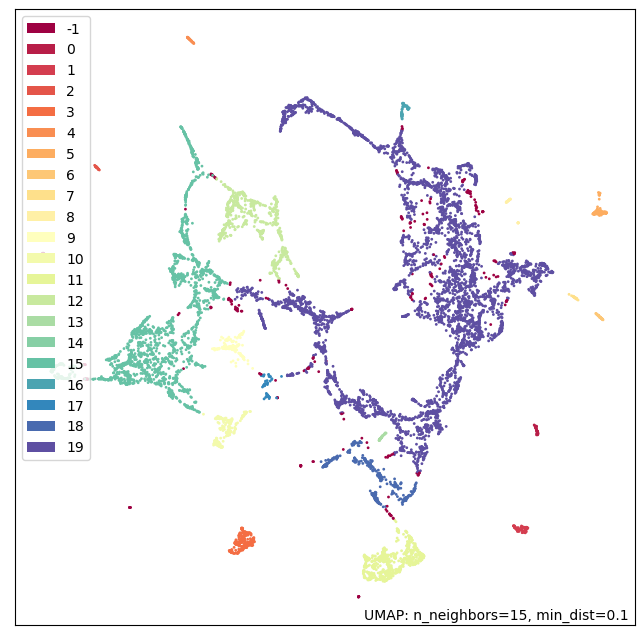

In [93]:
umap.plot.points(mapper, labels=hdbscan_labels)